In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from utils.ephys_functions import cross_corr_train, auto_corr_train, load_drift, load_auto_corr, load_cross_corr
from cross_auto_corr import cross_auto_corr
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.gridspec as gs
import numpy as np
from utils.combine_tools import apply_qc
%matplotlib inline


# Examples

In [2]:
session = 'behavior_751181_2025-02-25_12-12-35'
data_type = 'curated'
auto_corr = load_auto_corr(session, data_type)
cross_corr = load_cross_corr(session, data_type)
auto_corr.auto_corr_data['unit'].to_list()

[14, 19, 20, 23, 29, 30, 32, 33, 34, 168, 169]

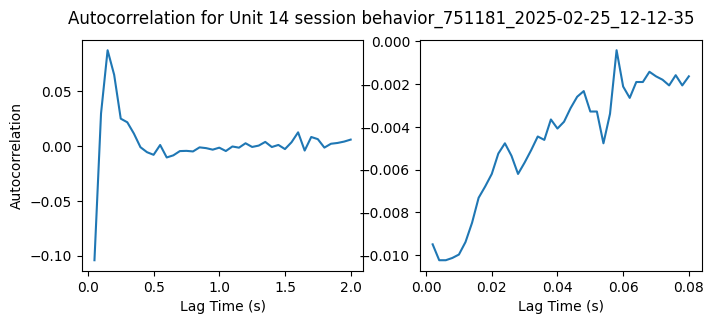

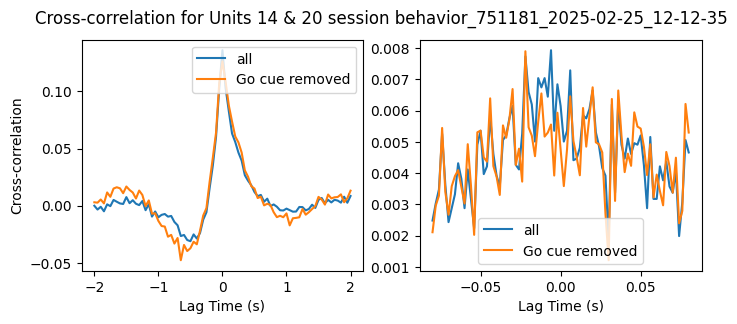

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: xlabel='Lag Time (s)', ylabel='Cross-correlation'>,
        <Axes: xlabel='Lag Time (s)'>], dtype=object))

In [3]:
unit_id = 14
unit_id_pair = (14, 20)
auto_unit = auto_corr.load_unit(unit_id)
auto_corr.plot_unit(unit_id)
pair_cross = cross_corr.load_units(unit_id_pair[0], unit_id_pair[1])
cross_corr.plot_units(unit_id_pair[0], unit_id_pair[1])


# Load data

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 18300 -> 8322 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8322 -> 5849 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5849 -> 5826 units passed
Applying conditional bounds for y_loc
 - y_loc: 5826 -> 4439 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 410
Number of non-opto units after filtering: 4439


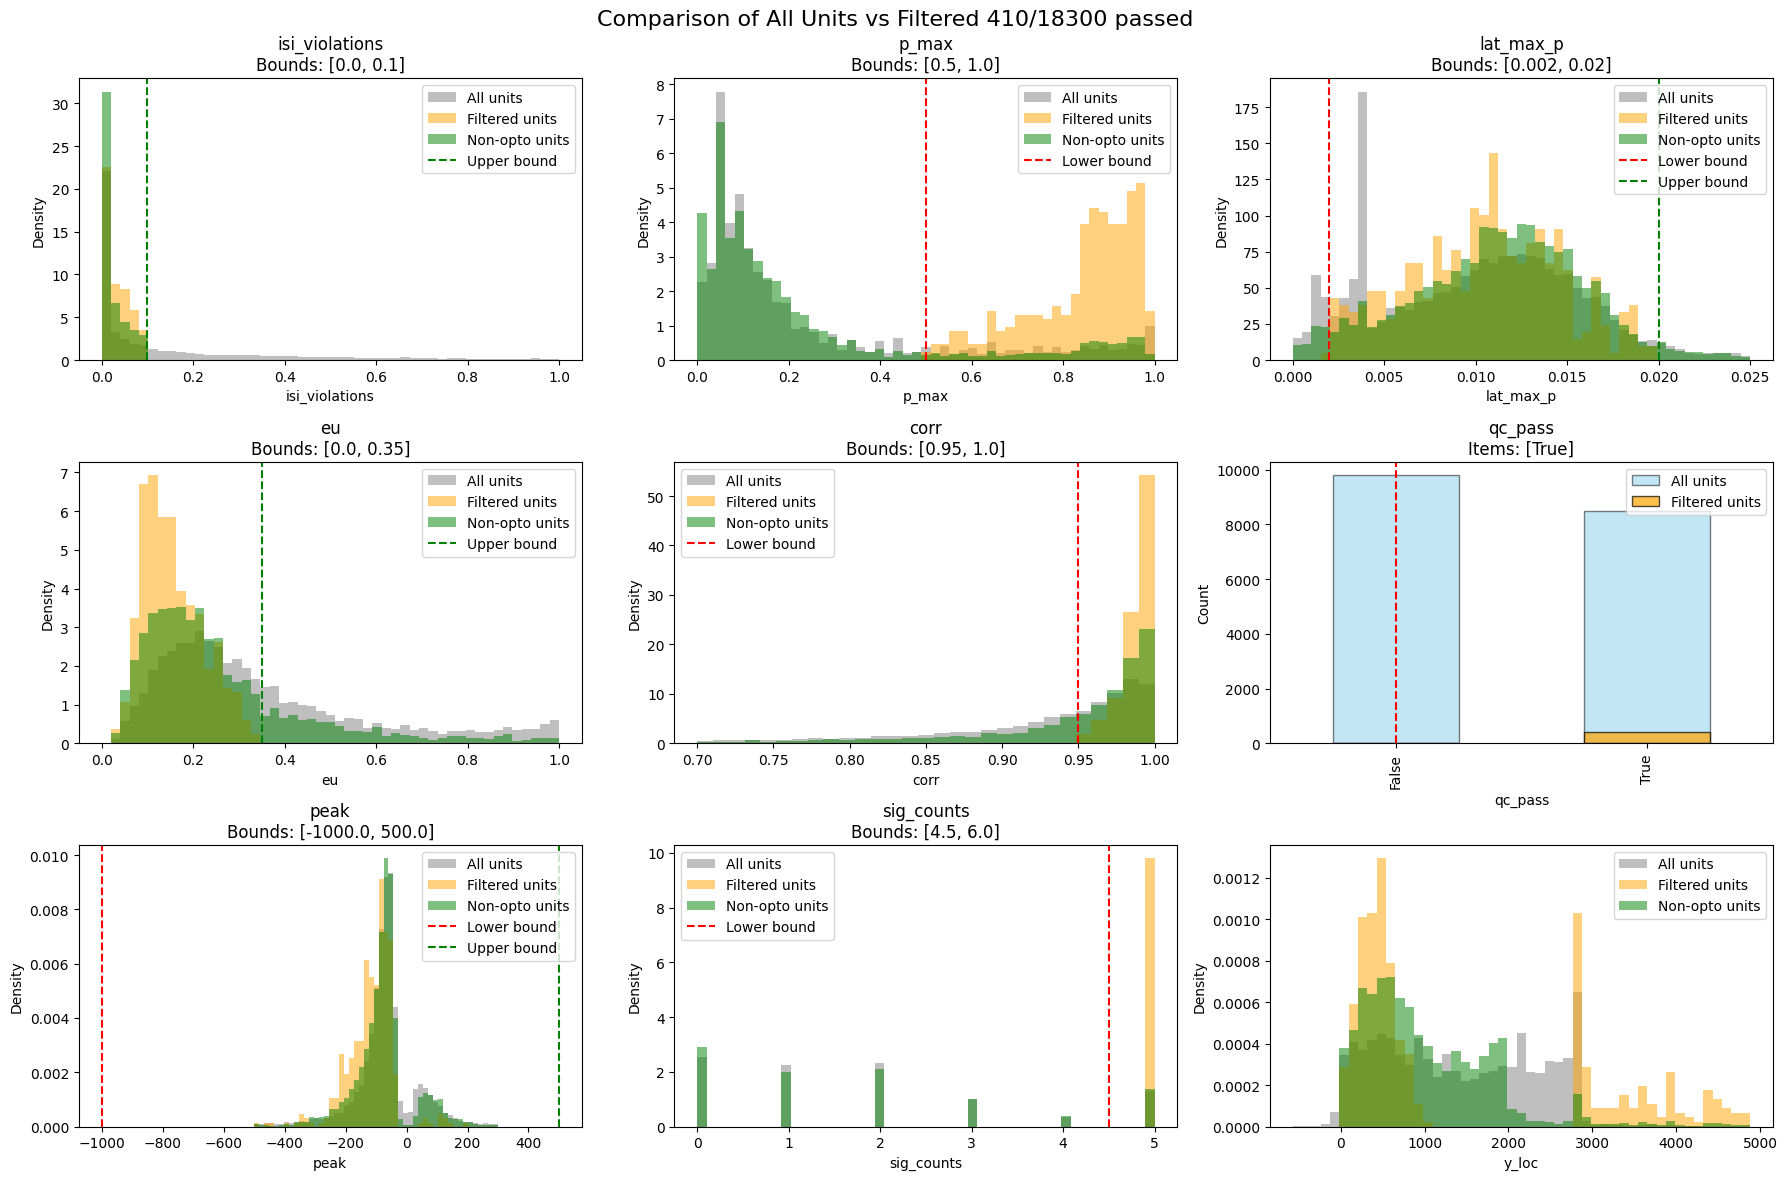

In [4]:
criteria_name = 'basic_ephys'
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [5]:
# loop trough all unit and load auto corr
auto_corr_list_long = []
auto_corr_list_short = []
lengths = []
for idx, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    data_type = 'curated'
    auto_corr = load_auto_corr(session, data_type)
    auto_unit = auto_corr.load_unit(unit_id)
    if auto_unit is None:
        auto_corr_list_long.append(None)
        auto_corr_list_short.append(None)
        lengths.append(np.nan)
    else:
        auto_corr_list_long.append(auto_unit['auto_corr_long_nogo'])
        auto_corr_list_short.append(auto_unit['auto_corr_short_nogo'])
        lengths.append(auto_unit['end'] - auto_unit['start'])

# append to dataframe
combined_tagged_units_filtered['auto_corr_long_nogo'] = auto_corr_list_long
combined_tagged_units_filtered['auto_corr_short_nogo'] = auto_corr_list_short
combined_tagged_units_filtered['length'] = lengths

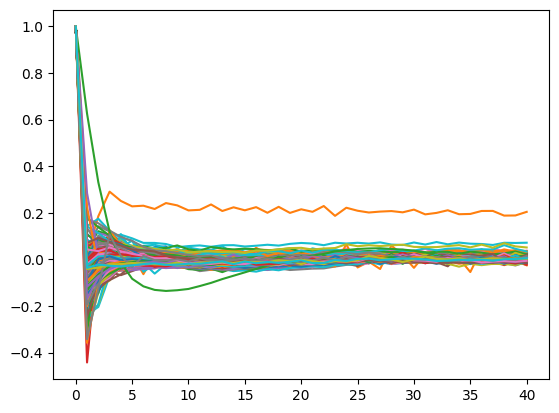

In [6]:
nan_ind = combined_tagged_units_filtered['auto_corr_long_nogo'].isna()
ac_nd = np.vstack(
    combined_tagged_units_filtered['auto_corr_long_nogo'][~nan_ind]
    .values
)
plt.plot(ac_nd[:].T);

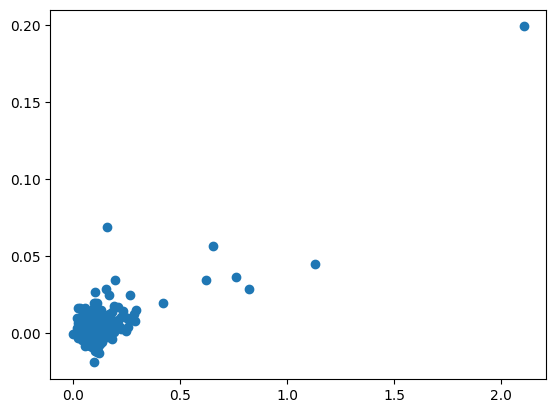

In [7]:
plt.scatter(combined_tagged_units_filtered['sd'][~nan_ind], np.mean(ac_nd[:, -10:], axis=1))

In [8]:
filter = (combined_tagged_units_filtered['sd'] < 0.3) & (combined_tagged_units_filtered['length'] > 1000)

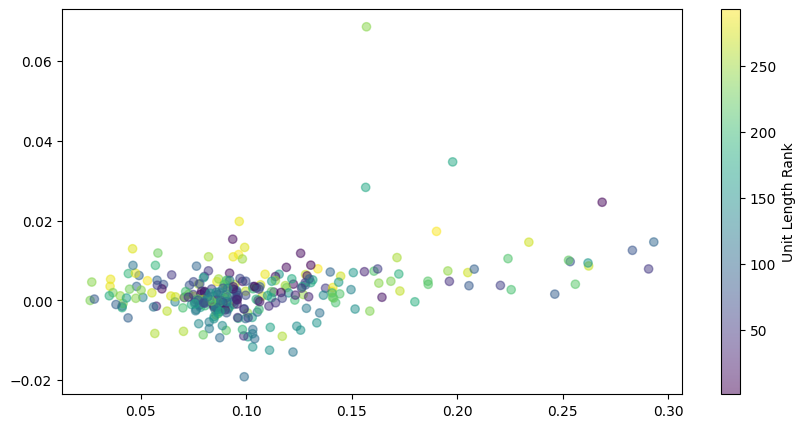

In [9]:
# import rankdata
from scipy.stats import rankdata
plt.figure(figsize=(10, 5))
ac_nd_filtered = np.vstack(combined_tagged_units_filtered['auto_corr_long_nogo'][~nan_ind & filter].values)
color_code = rankdata(combined_tagged_units_filtered['length'][~nan_ind & filter].values)
sg = plt.scatter(combined_tagged_units_filtered['sd'][~nan_ind & filter], np.mean(ac_nd_filtered[:, -10:], axis=1), c = color_code, cmap='viridis', alpha=0.5);
plt.colorbar(sg, label='Unit Length Rank')

In [10]:
combined_tagged_units_filtered = combined_tagged_units_filtered[filter].reset_index(drop=True)

In [11]:
# loop through sessions and find a table of session - unit_1 - unit_2 dataframe to load 
session_unit_pairs = []
for session in combined_tagged_units_filtered['session'].unique():
    session_df = combined_tagged_units_filtered[combined_tagged_units_filtered['session'] == session]
    unit_ids = session_df['unit'].to_list()
    for i in range(len(unit_ids)):
        for j in range(i+1, len(unit_ids)):
            session_unit_pairs.append((session, (unit_ids[i], unit_ids[j])))
session_unit_pairs_df = pd.DataFrame(session_unit_pairs, columns=['session', 'unit_pair'])

In [131]:
# load cross-corr for each session - unit pair
cross_corr_list = []
session_list = []
for idx, row in session_unit_pairs_df.iterrows():
    session = row['session']
    unit_pair = row['unit_pair']
    cross_corr = load_cross_corr(session, data_type)
    if cross_corr is not None:
        pair_cross = cross_corr.load_units(unit_pair[0], unit_pair[1])
        if pair_cross is not None:
            pair_cross['length'] = pair_cross['end'] - pair_cross['start']
            cross_corr_list.append(pair_cross)
            session_list.append(session)
    else:
        cross_corr_list.append(None)
        session_list.append(session)

In [132]:
cross_corr_df = pd.DataFrame(cross_corr_list)
cross_corr_df["session"] = session_list

# find location of each neuron, unit 1 and unit 2, load both ccf locations and y_loc (estimated location along the probe)
cross_corr_df['unit'] = cross_corr_df['unit_1']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 1
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_1', 'x_ccf': 'x_ccf_1', 'y_ccf': 'y_ccf_1', 'z_ccf': 'z_ccf_1'})
cross_corr_df['unit'] = cross_corr_df['unit_2']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 2
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_2', 'x_ccf': 'x_ccf_2', 'y_ccf': 'y_ccf_2', 'z_ccf': 'z_ccf_2'})

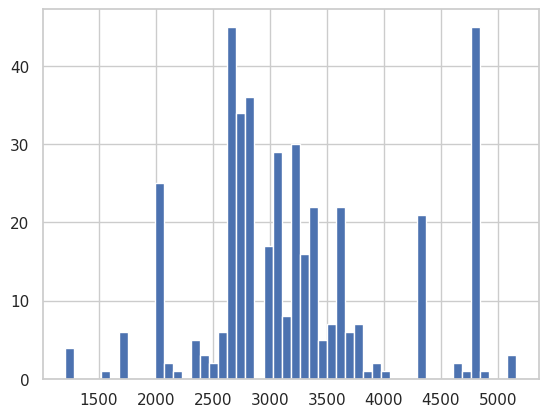

In [133]:
plt.hist(cross_corr_df['length'], bins=50);

In [137]:
cross_corr_df[cross_corr_df['length'] < 1500]['session']

99     behavior_751181_2025-02-26_11-51-19
102    behavior_751181_2025-02-26_11-51-19
105    behavior_751181_2025-02-26_11-51-19
106    behavior_751181_2025-02-26_11-51-19
Name: session, dtype: object

In [134]:
print(f'Total unit pairs with cross-corr data: {len(cross_corr_df)}')

Total unit pairs with cross-corr data: 416


# PCA analysis of crosscorr

Text(0.5, 1.0, 'Short timescale cross-corr (no-go)')

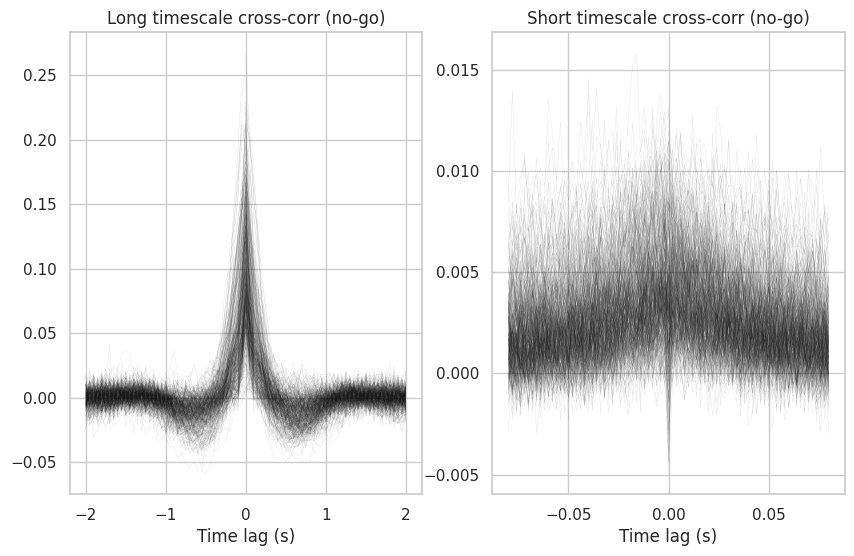

In [139]:
# plot all traces

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for idx, row in cross_corr_df.iterrows():
    pair_cross = row
    if pair_cross is not None:
        times = pair_cross['long_lags']
        corr_values = pair_cross['cross_corr_long_nogo']
        ax[0].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
        times = pair_cross['short_lags']
        corr_values = pair_cross['cross_corr_short_nogo']
        ax[1].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
ax[0].set_xlabel('Time lag (s)')
ax[0].set_title('Long timescale cross-corr (no-go)')
ax[1].set_xlabel('Time lag (s)')
ax[1].set_title('Short timescale cross-corr (no-go)')

Text(0.5, 1.0, 'Short timescale cross-corr center bin (no-go)')

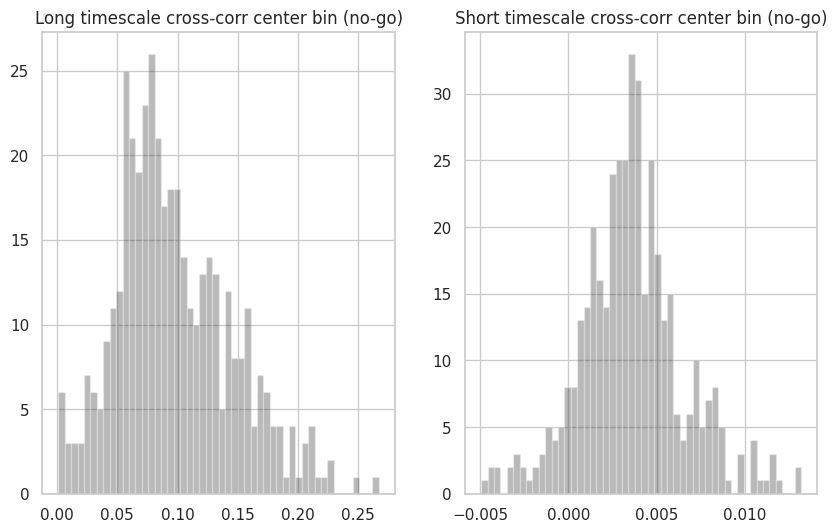

In [140]:
all_long_corr = np.array(cross_corr_df['cross_corr_long_nogo'].to_list())
all_short_corr = np.array(cross_corr_df['cross_corr_short_nogo'].to_list())
center_long = all_long_corr[:, all_long_corr.shape[1] // 2]
center_short = all_short_corr[:, all_short_corr.shape[1] // 2]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(center_long, bins=50, alpha=0.3, color='k');
ax[1].hist(center_short, bins=50, alpha=0.3, color='k');
ax[0].set_title('Long timescale cross-corr center bin (no-go)')
ax[1].set_title('Short timescale cross-corr center bin (no-go)')

In [141]:
# zscore
from scipy.stats import zscore
balanced_long_corr = all_long_corr - np.mean(all_long_corr, axis=0, keepdims=True)
balanced_long_corr = zscore(balanced_long_corr, axis=0)
# balanced_long_corr = zscore(balanced_long_corr, axis=0)
balanced_long_corr = np.concat([balanced_long_corr, np.flip(balanced_long_corr, 1)], axis=0)
all_long_corr_for_plot = np.concat([all_long_corr, np.flip(all_long_corr, 1)], axis=0)

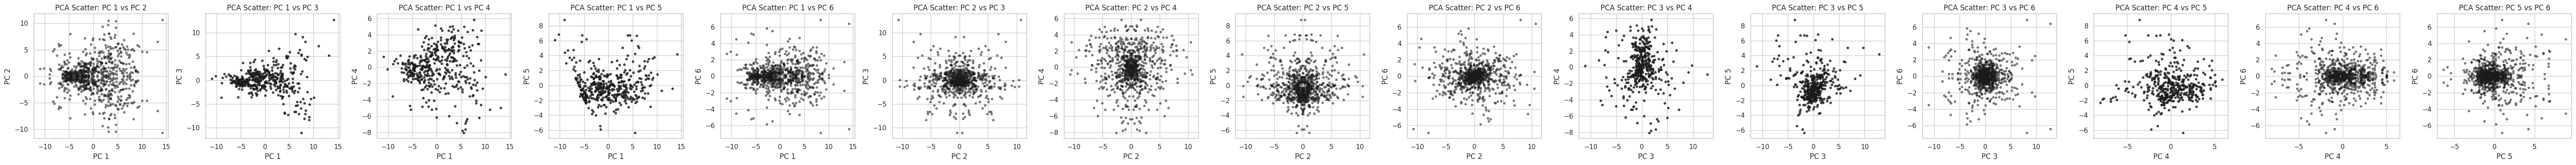

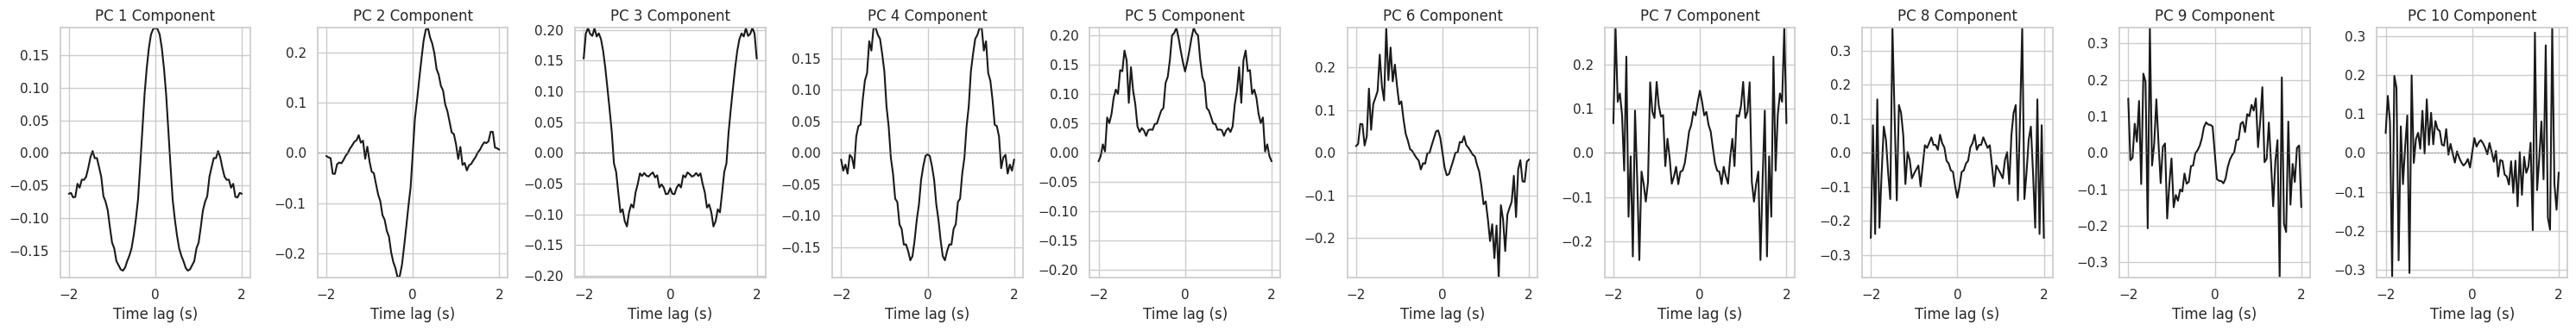

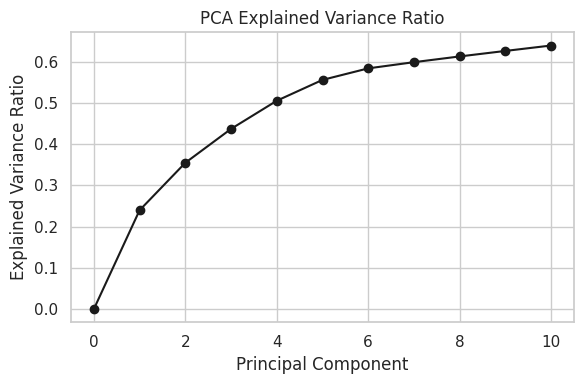

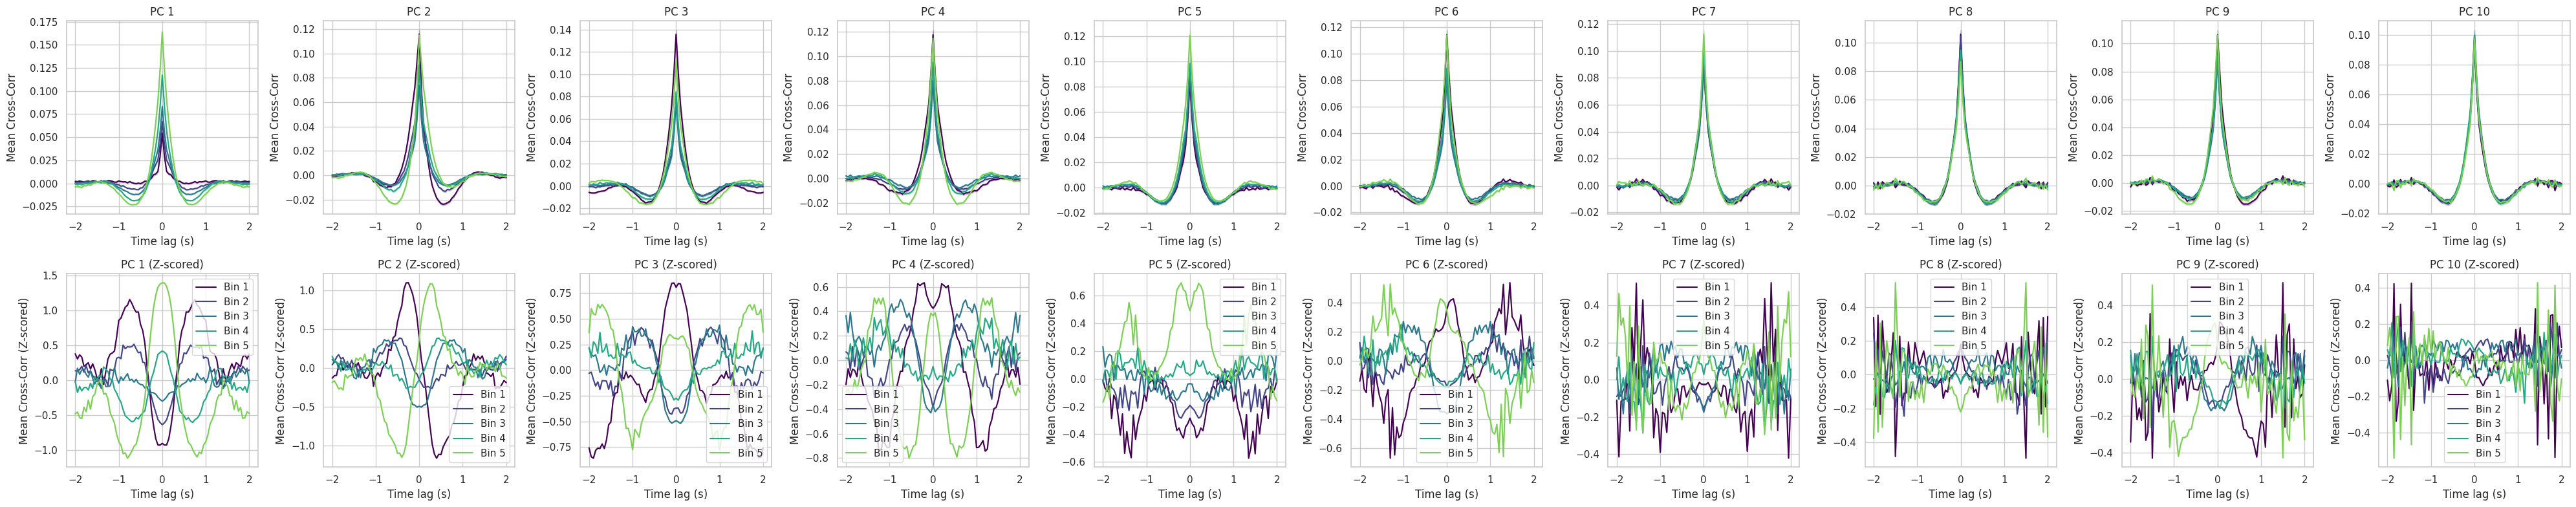

In [142]:
# pca on long timescale cross-corr
from sklearn.decomposition import PCA
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(balanced_long_corr)
long_corr_pca = pca.transform(balanced_long_corr)
import itertools
import matplotlib.pyplot as plt

def plot_pca_pairs(pca_data, max_components=None, figsize=(12, 4)):
    """
    pca_data: array (n_samples × n_components)
    max_components: number of components to visualize (default = all)
    """

    # Determine how many components to use
    n_components = pca_data.shape[1]
    if max_components is not None:
        n_components = min(max_components, n_components)

    component_indices = range(n_components)

    # Generate all unique pairs: (0,1), (0,2), (1,2), ...
    pairs = list(itertools.combinations(component_indices, 2))

    # Determine layout
    n_plots = len(pairs)
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), squeeze=False)
    axes = axes.ravel()

    # Plot each pair
    for ax, (i, j) in zip(axes, pairs):
        ax.scatter(pca_data[:, i], pca_data[:, j], alpha=0.5, color='k', s=10)
        ax.set_xlabel(f"PC {i+1}")
        ax.set_ylabel(f"PC {j+1}")
        ax.set_title(f"PCA Scatter: PC {i+1} vs PC {j+1}")

    plt.tight_layout()
    return fig, axes

fig, axes = plot_pca_pairs(long_corr_pca, max_components=6)

# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['long_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()


# plot mean of cross correltions binned by score of each pc
num_bins = 5
fig, axes = plt.subplots(2, num_components, figsize=(4*num_components, 8))
for pc_idx in range(num_components):
    pc_scores = long_corr_pca[:, pc_idx]
    bin_edges = np.percentile(pc_scores, np.linspace(0, 100, num_bins + 1))
    binned_means = []
    binned_means_ori = []
    binned_sems = []
    binned_sems_ori = []
    for i in range(num_bins):
        bin_mask = (pc_scores >= bin_edges[i]) & (pc_scores < bin_edges[i + 1])
        bin_data = all_long_corr_for_plot[bin_mask]
        bin_data_ori = balanced_long_corr[bin_mask]
        mean_corr = np.mean(bin_data, axis=0)
        mean_corr_ori = np.mean(bin_data_ori, axis=0)
        sem_corr = np.std(bin_data, axis=0) / np.sqrt(bin_data.shape[0])
        sem_corr_ori = np.std(bin_data_ori, axis=0) / np.sqrt(bin_data_ori.shape[0])
        binned_means.append(mean_corr)
        binned_means_ori.append(mean_corr_ori)
        binned_sems.append(sem_corr)
        binned_sems_ori.append(sem_corr)
    
    # Plotting
    ax = axes[0, pc_idx]
    lags = cross_corr_df.iloc[0]['long_lags']
    for i in range(num_bins):
        ax.plot(lags, binned_means[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means[i] - binned_sems[i], 
                        binned_means[i] + binned_sems[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1}')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr')
    
    ax = axes[1, pc_idx]
    for i in range(num_bins):
        ax.plot(lags, binned_means_ori[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means_ori[i] - binned_sems_ori[i], 
                        binned_means_ori[i] + binned_sems_ori[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1} (Z-scored)')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr (Z-scored)')

    ax.legend()
    plt.tight_layout()

In [143]:
# flip units based on sign of PC2
cross_corr_df_flipped = cross_corr_df.copy()
scores_pc2 = pca.transform(balanced_long_corr[:len(all_long_corr), :])[ :, 1]
flip_indices = scores_pc2 < 0
cross_corr_df_flipped.loc[flip_indices, 'unit_1'], cross_corr_df_flipped.loc[flip_indices, 'unit_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'unit_2'], cross_corr_df_flipped.loc[flip_indices, 'unit_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'].values
cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'].apply(lambda x: np.flip(x))
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'].apply(lambda x: np.flip(x))

In [144]:
PC_1 = long_corr_pca[:len(all_long_corr), 0]
cross_corr_df['PC_1'] = rankdata(PC_1)

In [145]:
peak_win = [0, 7]
inhi_win = [7, 30]

In [2]:
distance_y_abs = np.abs(cross_corr_df['y_loc_2'].values - cross_corr_df['y_loc_1'].values)
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
distance_y_abs[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
distance_y = (cross_corr_df['y_loc_2'].values - cross_corr_df['y_loc_1'].values)
distance_y[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
mean_z_ccf = (cross_corr_df['z_ccf_1'].values + cross_corr_df['z_ccf_2'].values) / 2 - bregma_LPS_mm[2]
mean_z_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
mean_y_ccf = (cross_corr_df['y_ccf_1'].values + cross_corr_df['y_ccf_2'].values) / 2 - bregma_LPS_mm[1]
mean_y_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
mean_x_ccf = np.abs((cross_corr_df['x_ccf_1'].values + cross_corr_df['x_ccf_2'].values) / 2 - bregma_LPS_mm[0])
mean_x_ccf[cross_corr_df['session'].apply(lambda x: 'ZS' in x).values] = np.nan  # exclude old sessions for y distance
peak_cross = [cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2] for i in range(len(cross_corr_df))]
peak_cross = np.array(peak_cross)
peak_win_cross = [np.mean(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - peak_win[1]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + peak_win[1]]) for i in range(len(cross_corr_df))]
peak_win_cross = np.array(peak_win_cross)
inhi_win_cross_outer = [np.sum(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[1]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[1]]) for i in range(len(cross_corr_df))]
inhi_win_cross_outer = np.array(inhi_win_cross_outer)
inhi_win_cross_inner = [np.sum(cross_corr_df.iloc[i]['cross_corr_long_nogo'][len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 - inhi_win[0]: len(cross_corr_df.iloc[i]['cross_corr_long_nogo']) // 2 + inhi_win[0]]) for i in range(len(cross_corr_df))]
inhi_win_cross_inner = np.array(inhi_win_cross_inner)
inhi_win_cross = inhi_win_cross_outer - inhi_win_cross_inner

# # rank ccf location
mean_x_ccf[~np.isnan(mean_x_ccf)] = rankdata(mean_x_ccf[~np.isnan(mean_x_ccf)])
mean_y_ccf[~np.isnan(mean_y_ccf)] = rankdata(mean_y_ccf[~np.isnan(mean_y_ccf)])
mean_z_ccf[~np.isnan(mean_z_ccf)] = rankdata(mean_z_ccf[~np.isnan(mean_z_ccf)])

# rank peak cross
peak_cross[~np.isnan(peak_cross)] = rankdata(peak_cross[~np.isnan(peak_cross)])

cross_corr_df['distance_y_abs'] = distance_y_abs
cross_corr_df['distance_y'] = distance_y
cross_corr_df['mean_z_ccf'] = mean_z_ccf
cross_corr_df['mean_y_ccf'] = mean_y_ccf
cross_corr_df['mean_x_ccf'] = mean_x_ccf

cross_corr_df['peak_cross'] = peak_cross
cross_corr_df['inhi_win_cross'] = inhi_win_cross
cross_corr_df['peak_win_cross'] = peak_win_cross

list_to_plot = ['PC_1', 'distance_y_abs', 'distance_y', 'peak_cross', 'mean_z_ccf', 'mean_y_ccf', 'mean_x_ccf', 'inhi_win_cross', 'peak_win_cross']

NameError: name 'np' is not defined

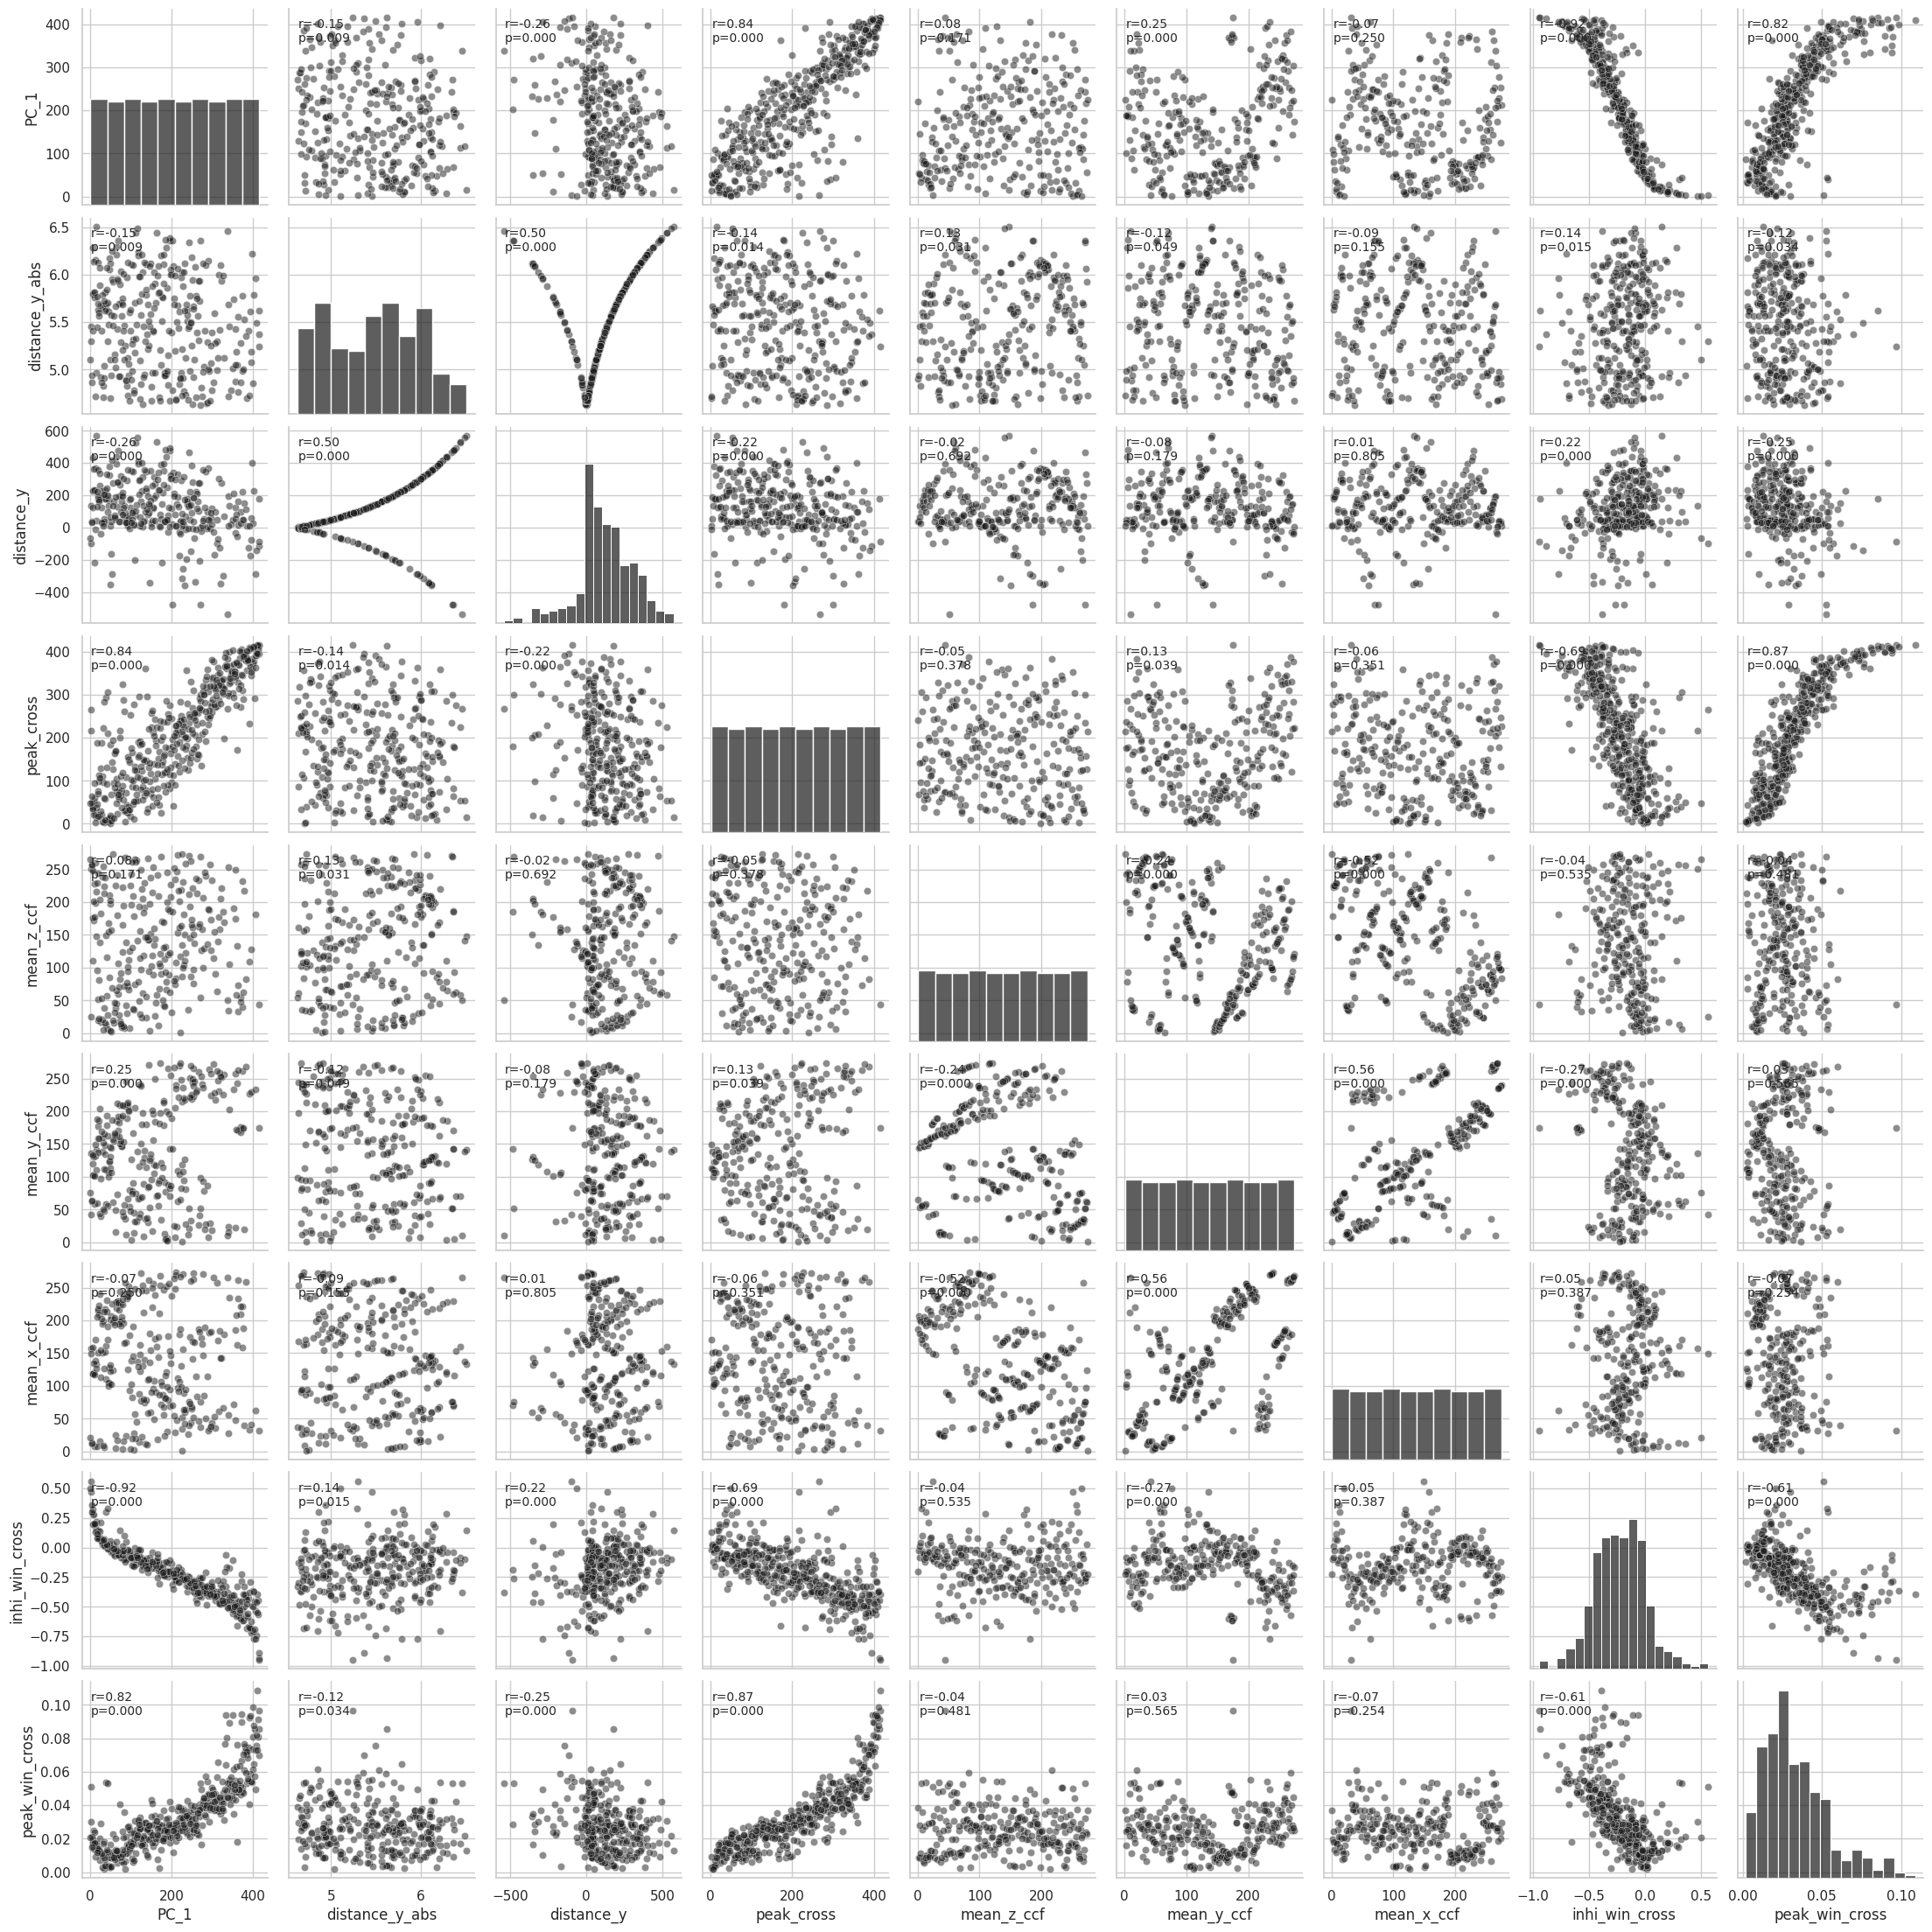

In [147]:
import seaborn as sns
sns.set(style="whitegrid", context='notebook')

pairplot = sns.pairplot(
    cross_corr_df[list_to_plot],
    diag_kind='hist',                         # <-- change to histogram
    plot_kws={'alpha': 0.5, 'color': 'k'},
    diag_kws={'color': 'k', 'alpha': 0.7}     # optional histogram styling
)

# Add correlation coefficients and significance values
for i, j in zip(*np.triu_indices_from(pairplot.axes, 1)):
    x_var = list_to_plot[j]
    y_var = list_to_plot[i]

    x = cross_corr_df[x_var]
    y = cross_corr_df[y_var]
    valid_mask = ~x.isna() & ~y.isna()

    if valid_mask.sum() > 2:
        corr_coef = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]

        from scipy.stats import pearsonr
        p_value = pearsonr(x[valid_mask], y[valid_mask])[1]

        pairplot.axes[i, j].annotate(
            f'r={corr_coef:.2f}\np={p_value:.3f}',
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            ha='left',
            va='top',
            fontsize=10
        )

        pairplot.axes[j, i].annotate(
            f'r={corr_coef:.2f}\np={p_value:.3f}',
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            ha='left',
            va='top',
            fontsize=10
        )


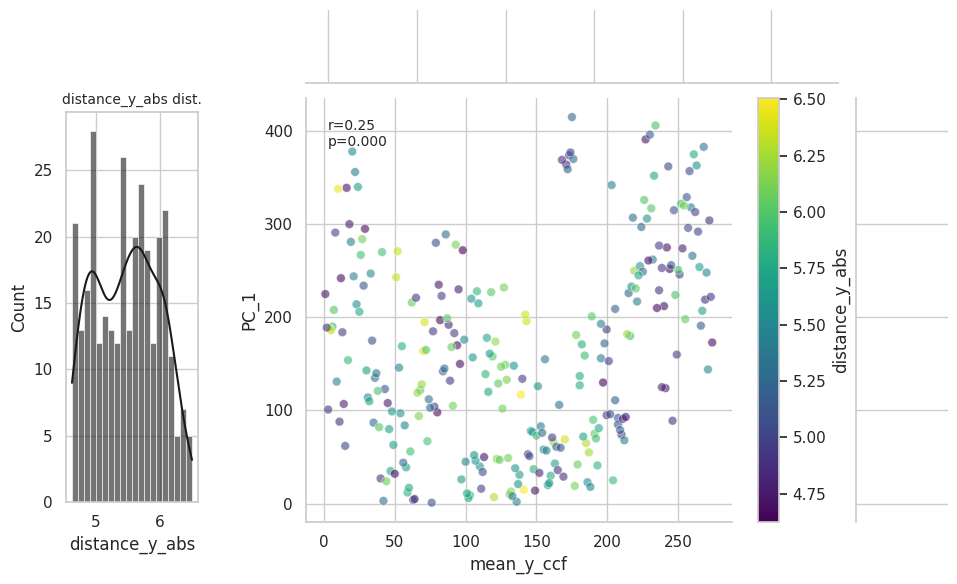

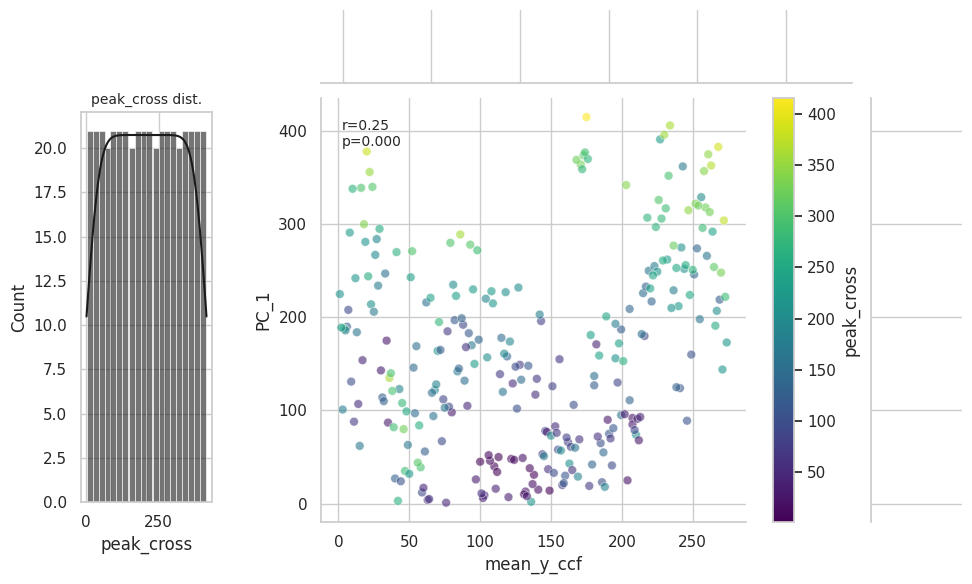

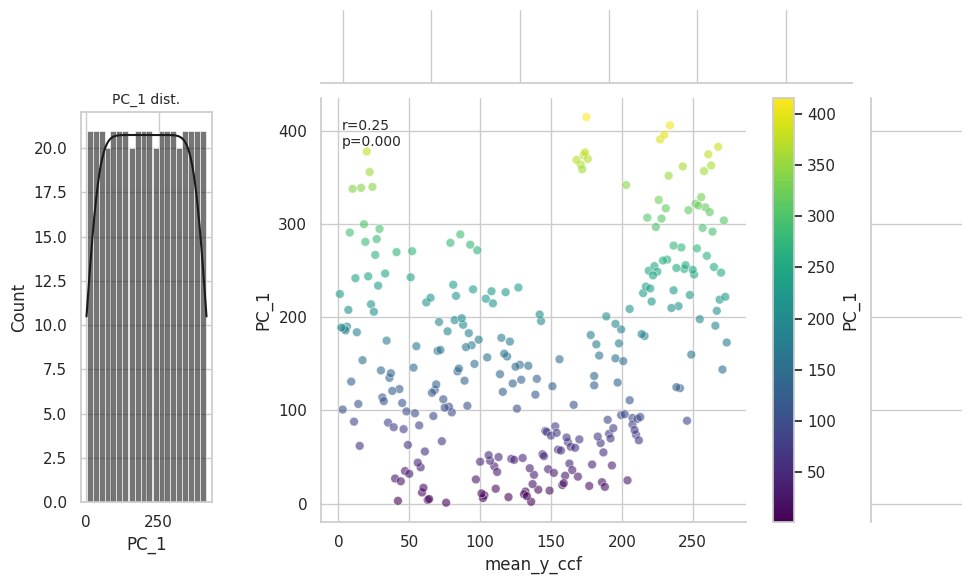

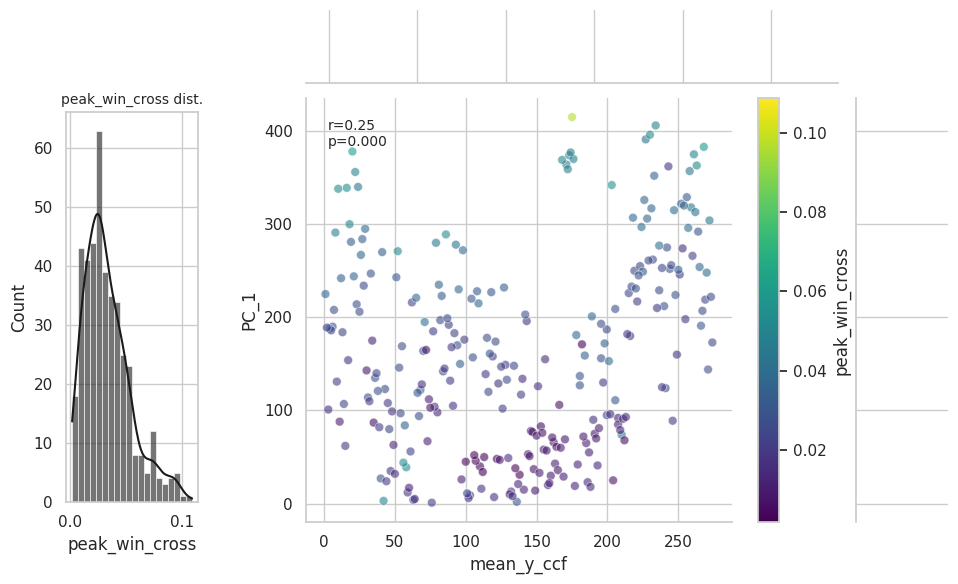

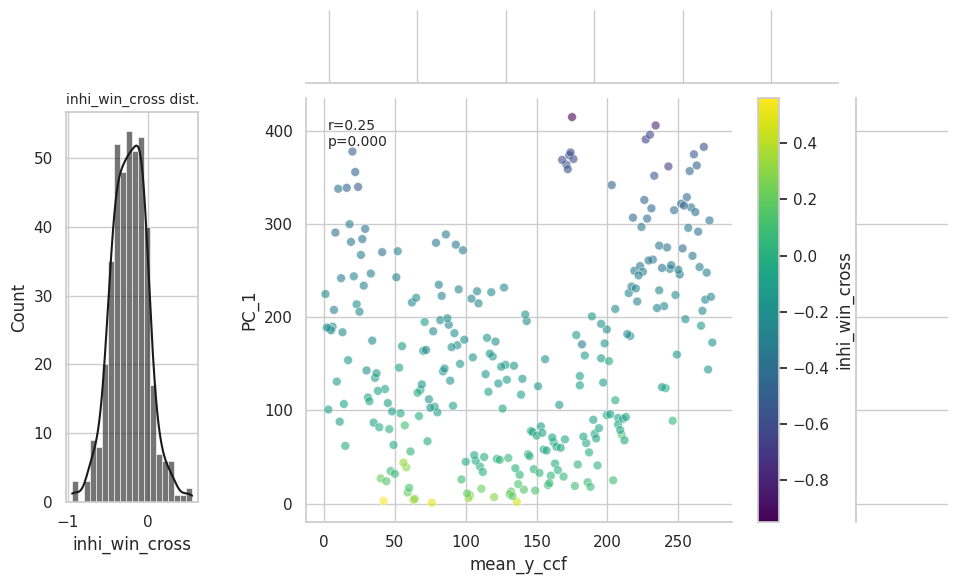

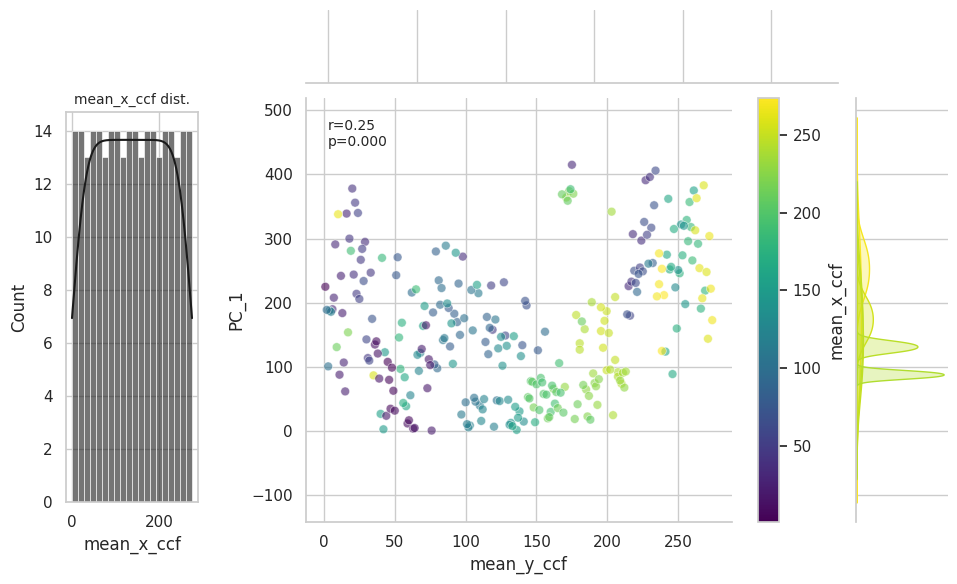

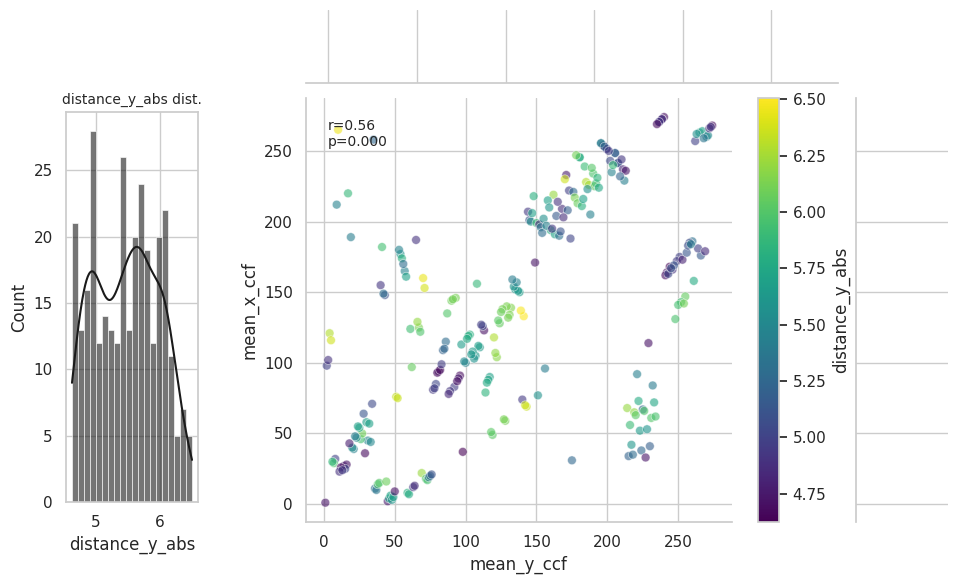

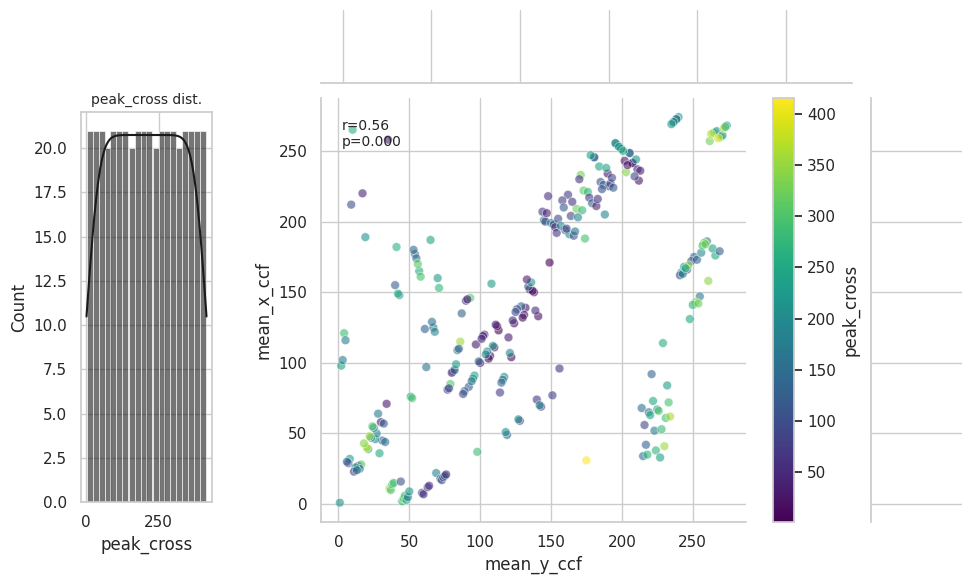

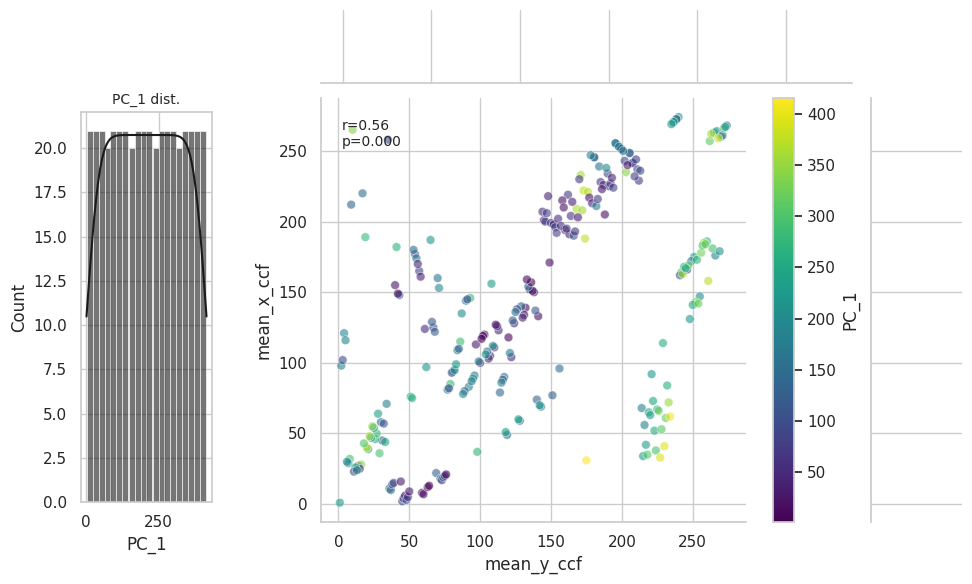

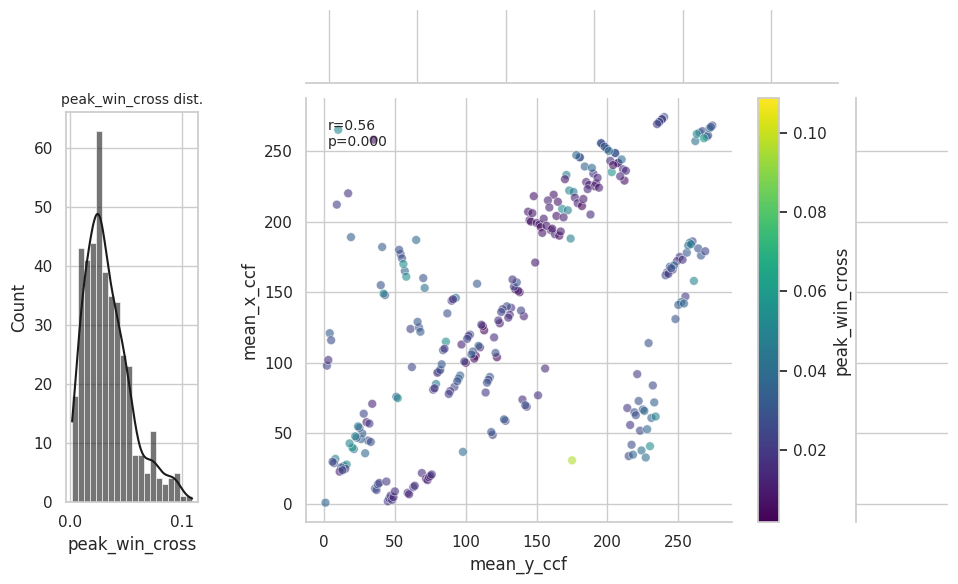

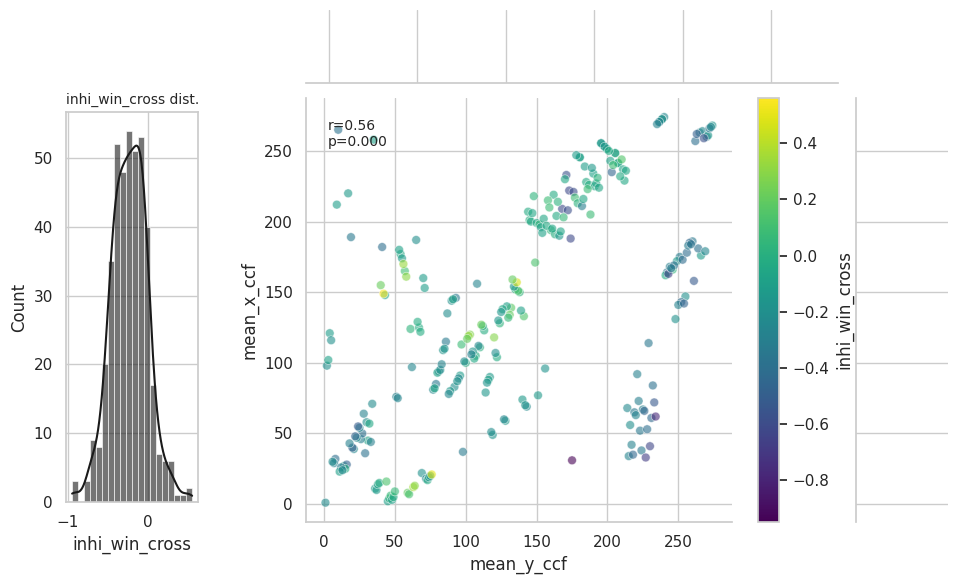

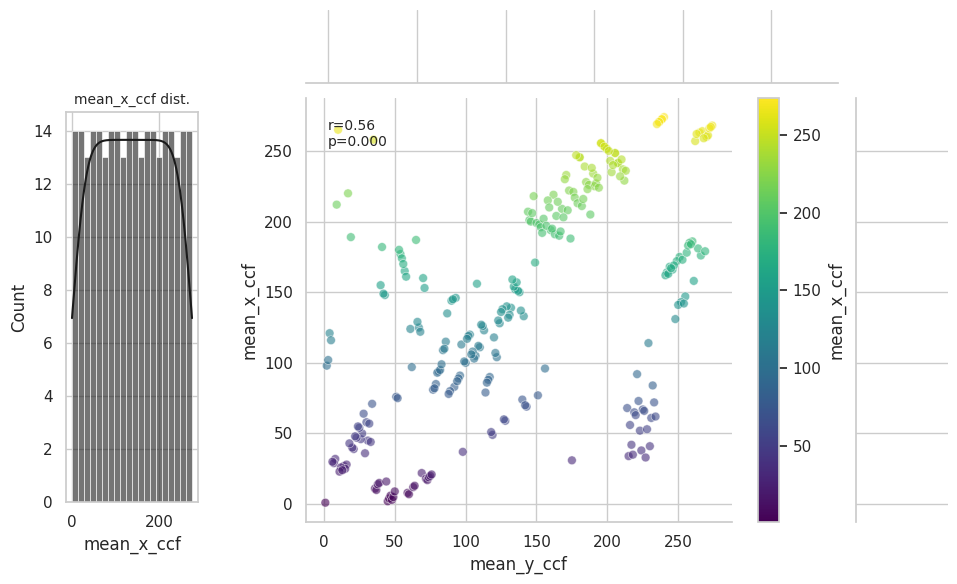

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

x_vars = ['mean_y_ccf']     # example: add more if needed
y_vars = ['PC_1', 'mean_x_ccf']                 # example: add more if needed
color_codes = ['distance_y_abs', 'peak_cross', 'PC_1', 'peak_win_cross', 'inhi_win_cross', 'mean_x_ccf']

for x_var in x_vars:
    for y_var in y_vars:
        for color_code in color_codes:

            # --- main jointplot ---
            g = sns.jointplot(
                data=cross_corr_df,
                x=x_var,
                y=y_var,
                hue=color_code,
                palette='viridis',
                kind='scatter',
                height=6,
                joint_kws={'s': 40, 'alpha': 0.6},
                marginal_kws={'alpha': 0.3}
            )

            # --- correlation annotation ---
            valid_mask = cross_corr_df[x_var].notna() & cross_corr_df[y_var].notna()
            corr_coef = np.corrcoef(
                cross_corr_df[x_var][valid_mask],
                cross_corr_df[y_var][valid_mask]
            )[0, 1]
            p_value = pearsonr(
                cross_corr_df[x_var][valid_mask],
                cross_corr_df[y_var][valid_mask]
            )[1]

            g.ax_joint.annotate(
                f'r={corr_coef:.2f}\np={p_value:.3f}',
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                ha='left',
                va='top',
                fontsize=10
            )

            # remove legend if it exists (seaborn 0.13 safe)
            if hasattr(g.ax_joint, "legend_") and g.ax_joint.legend_:
                g.ax_joint.legend_.remove()

            # --- colorbar ---
            norm = plt.Normalize(
                vmin=cross_corr_df[color_code].min(),
                vmax=cross_corr_df[color_code].max()
            )
            sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
            sm.set_array([])

            # -----------------------------------------------------------
            # ADD LEFT DISTRIBUTION AXIS (WIDE, NOT OVERLAPPING)
            # -----------------------------------------------------------

            # move the jointplot rightward (reserve space on left)
            g.fig.subplots_adjust(left=-0.1)

            # add histogram in the reserved area
            left_ax = g.fig.add_axes([-0.5, 0.15, 0.22, 0.65])
            #        [left, bottom, width, height]

            sns.histplot(
                cross_corr_df[color_code],
                ax=left_ax,
                color='k',
                bins=20,
                alpha=0.6,
                kde=True
            )
            left_ax.set_xlabel(color_code)
            left_ax.set_ylabel("Count")
            left_ax.set_title(f"{color_code} dist.", fontsize=10)

            # --- colorbar on the right of scatter
            g.fig.colorbar(sm, ax=g.ax_joint, label=color_code)

            # final layout
            plt.show()


In [149]:
peak_find = np.where(np.array(peak_cross) > 0.25)[0]
cross_corr_df.iloc[peak_find][['session', 'unit_1', 'unit_2']]

session     unit_1     unit_2
0    behavior_716325_2024-05-31_10-31-14       87.0      377.0
1    behavior_716325_2024-05-31_10-31-14       87.0      379.0
2    behavior_716325_2024-05-31_10-31-14      377.0      379.0
3    behavior_751004_2024-12-20_13-26-11         40        263
4    behavior_751004_2024-12-20_13-26-11         40        268
..                                   ...        ...        ...
411   behavior_ZS062_2021-05-04_14-29-20  TT6_SS_02  TT6_SS_03
412   behavior_ZS062_2021-05-05_16-34-46  TT6_SS_01  TT6_SS_02
413   behavior_ZS062_2021-05-06_15-46-14  TT6_SS_01  TT6_SS_02
414   behavior_ZS062_2021-05-07_17-38-21  TT6_SS_01  TT6_SS_02
415   behavior_ZS062_2021-05-10_19-15-51  TT2_SS_01  TT7_SS_01

[416 rows x 3 columns]

In [150]:
error_ind = (cross_corr_df['mean_y_ccf']>150) & (cross_corr_df['mean_y_ccf']<200) & (cross_corr_df['PC_1']>300)
cross_corr_df[error_ind][['session', 'unit_1', 'unit_2']]

session unit_1 unit_2
179  behavior_758018_2025-03-19_11-16-44      9     10
180  behavior_758018_2025-03-19_11-16-44      9     13
181  behavior_758018_2025-03-19_11-16-44      9     18
182  behavior_758018_2025-03-19_11-16-44     10     13
183  behavior_758018_2025-03-19_11-16-44     10     18
184  behavior_758018_2025-03-19_11-16-44     13     18
275  behavior_784806_2025-06-20_13-39-16     72    649

In [158]:
error_ind = (cross_corr_df['mean_y_ccf']>200) & (cross_corr_df['mean_x_ccf']<100)
cross_corr_df[error_ind]['session'].unique()

array(['behavior_791691_2025-06-27_13-54-30'], dtype=object)

<Figure size 600x600 with 0 Axes>

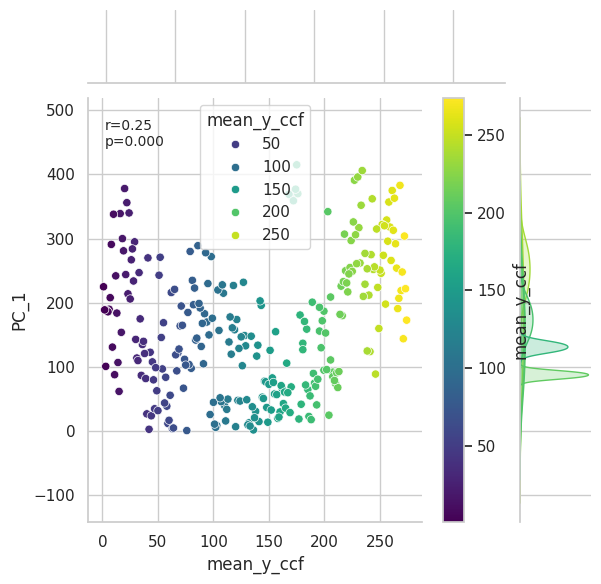

<Figure size 600x600 with 0 Axes>

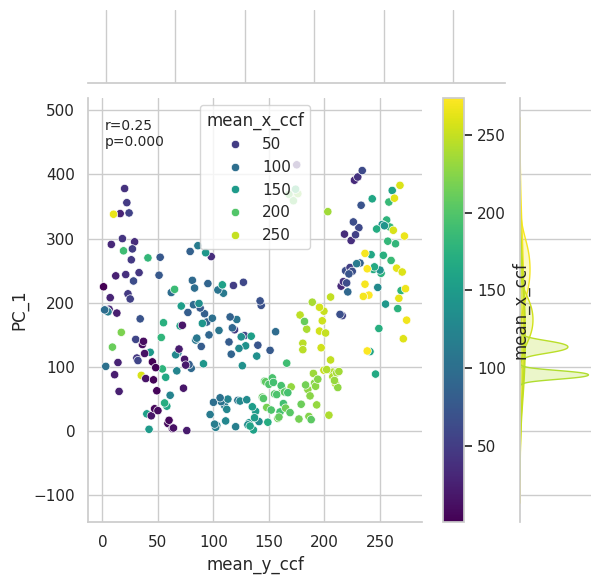

<Figure size 600x600 with 0 Axes>

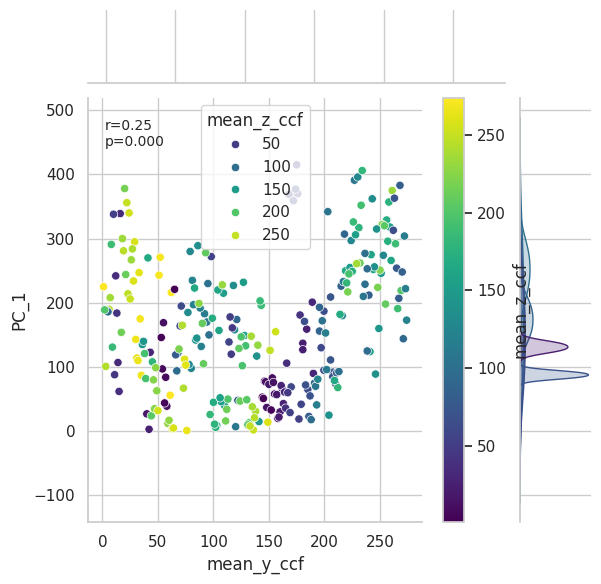

In [151]:
# scatter pc1 vs distance y, color by mean y loc
x_var = 'mean_y_ccf'
y_var = 'PC_1'
color_codes = ['mean_y_ccf', 'mean_x_ccf', 'mean_z_ccf']
for color_code in color_codes:
    plt.figure(figsize=(6, 6))

    g = sns.jointplot(
        data=cross_corr_df,
        x=x_var,
        y=y_var,
        hue=color_code,
        palette='viridis',
        kind='scatter',
        height=6,
    )

    # add coeff and p significance
    from scipy.stats import pearsonr
    valid_mask = ~cross_corr_df[x_var].isna() & ~cross_corr_df[y_var].isna()
    corr_coef = np.corrcoef(cross_corr_df[x_var][valid_mask], cross_corr_df[y_var][valid_mask])[0, 1]
    p_value = pearsonr(cross_corr_df[x_var][valid_mask], cross_corr_df[y_var][valid_mask])[1]
    g.ax_joint.annotate(
        f'r={corr_coef:.2f}\np={p_value:.3f}',
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        ha='left',
        va='top',
        fontsize=10
    )
    # add color bar
    norm = plt.Normalize(cross_corr_df[color_code].min(), cross_corr_df[color_code].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    g.fig.colorbar(sm, ax=g.ax_joint, label=color_code)


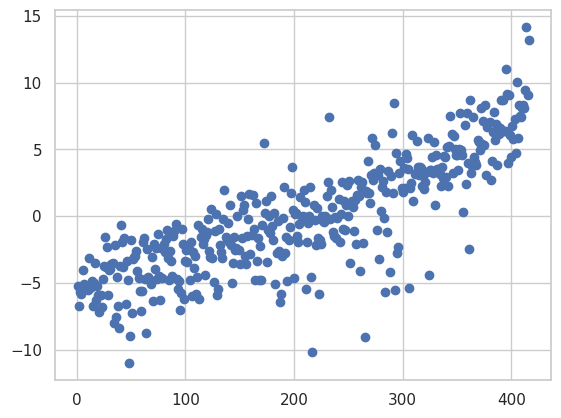

In [152]:
plt.scatter(peak_cross, PC_1);

In [153]:
# redo PCA with flipped data
flipped_long_corr = np.array(cross_corr_df_flipped['cross_corr_long_nogo'].to_list())
flipped_long_corr_plot = flipped_long_corr.copy()
flipped_long_corr = zscore(flipped_long_corr, axis=0)

In [154]:
# redo PCA with flipped data
from scipy.stats import zscore
flipped_long_corr = np.array(cross_corr_df_flipped['cross_corr_long_nogo'].to_list())
flipped_long_corr_plot = flipped_long_corr.copy()
flipped_long_corr = zscore(flipped_long_corr, axis=0)

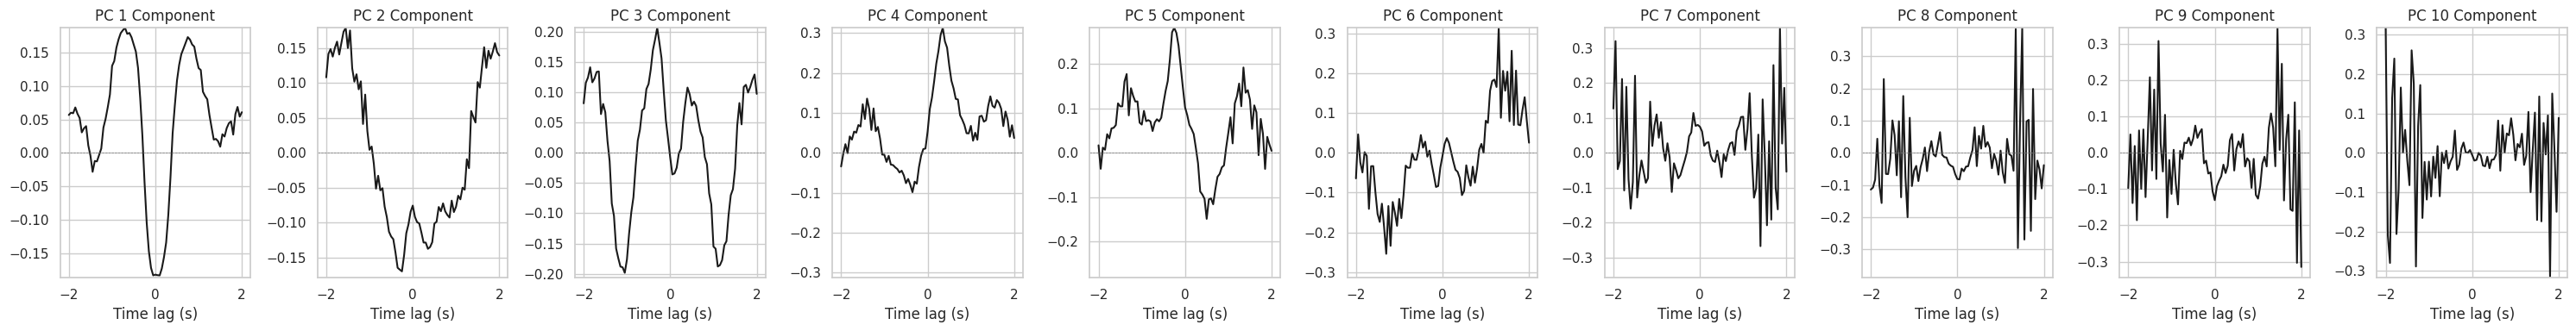

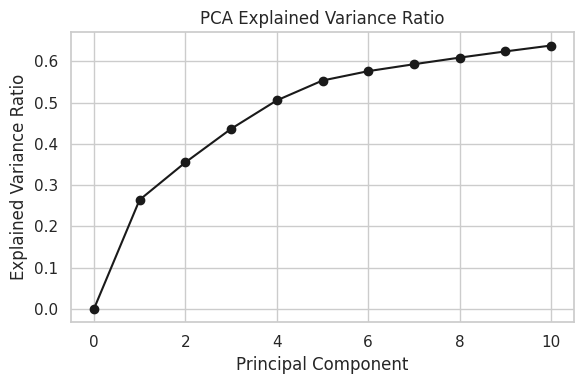

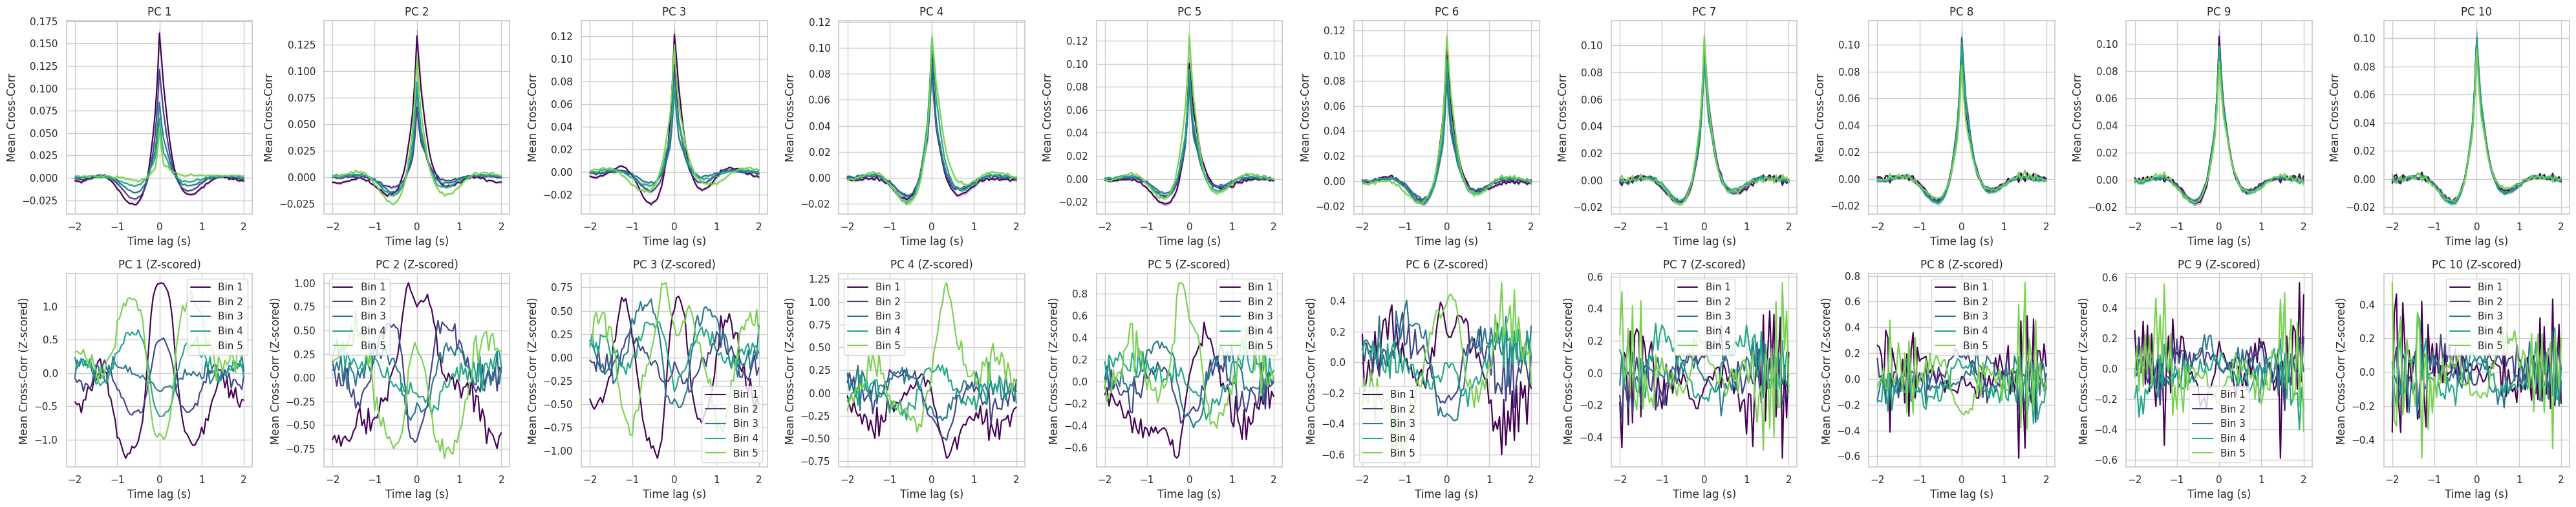

In [155]:
# pca on long timescale cross-corr
from sklearn.decomposition import PCA
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(flipped_long_corr)
long_corr_pca = pca.transform(flipped_long_corr)
import itertools
import matplotlib.pyplot as plt

# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['long_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()

# plot mean of cross correltions binned by score of each pc
num_bins = 5
fig, axes = plt.subplots(2, num_components, figsize=(4*num_components, 8))
for pc_idx in range(num_components):
    pc_scores = long_corr_pca[:, pc_idx]
    bin_edges = np.percentile(pc_scores, np.linspace(0, 100, num_bins + 1))
    binned_means = []
    binned_means_ori = []
    binned_sems = []
    binned_sems_ori = []
    for i in range(num_bins):
        bin_mask = (pc_scores >= bin_edges[i]) & (pc_scores < bin_edges[i + 1])
        bin_data = flipped_long_corr_plot[bin_mask]
        bin_data_ori = flipped_long_corr[bin_mask]
        mean_corr = np.mean(bin_data, axis=0)
        mean_corr_ori = np.mean(bin_data_ori, axis=0)
        sem_corr = np.std(bin_data, axis=0) / np.sqrt(bin_data.shape[0])
        sem_corr_ori = np.std(bin_data_ori, axis=0) / np.sqrt(bin_data_ori.shape[0])
        binned_means.append(mean_corr)
        binned_means_ori.append(mean_corr_ori)
        binned_sems.append(sem_corr)
        binned_sems_ori.append(sem_corr)

    # Plotting
    ax = axes[0, pc_idx]
    lags = cross_corr_df.iloc[0]['long_lags']
    for i in range(num_bins):
        ax.plot(lags, binned_means[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means[i] - binned_sems[i], 
                        binned_means[i] + binned_sems[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1}')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr')
    ax = axes[1, pc_idx]
    for i in range(num_bins):
        ax.plot(lags, binned_means_ori[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means_ori[i] - binned_sems_ori[i], 
                        binned_means_ori[i] + binned_sems_ori[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1} (Z-scored)')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr (Z-scored)')
    ax.legend()
    plt.tight_layout()
# save flipped dataframe
